In [1]:
library(tidyverse)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




# Table 1

In [125]:
train_data <- read_tsv('data/filtered/train.tsv.gz', col_types = cols_only(sample_barcode = col_character(), 
                                                                           source = col_character(),
                                                                           cancer = col_character()))

In [128]:
train_data %>% 
    group_by(source, cancer) %>% 
    tally %>%
    mutate(cancer = cancer %>% recode_factor('0' = 'Normal', '1' = 'Cancer')) %>%
    pivot_wider(names_from = cancer, values_from = n)

source,Normal,Cancer
<chr>,<int>,<int>
BLCA,408,19
BRCA,1100,112
CESC,306,3
CHOL,36,9
COAD,287,41
ESCA,185,11
GBM,166,5
HNSC,522,44
KICH,66,25


# Plots

In [8]:
cancer_df <- read_tsv('cancer_performance_300.tsv', col_types = cols())
tissue_df <- read_tsv('tissue_performance_300.tsv', col_types = cols())

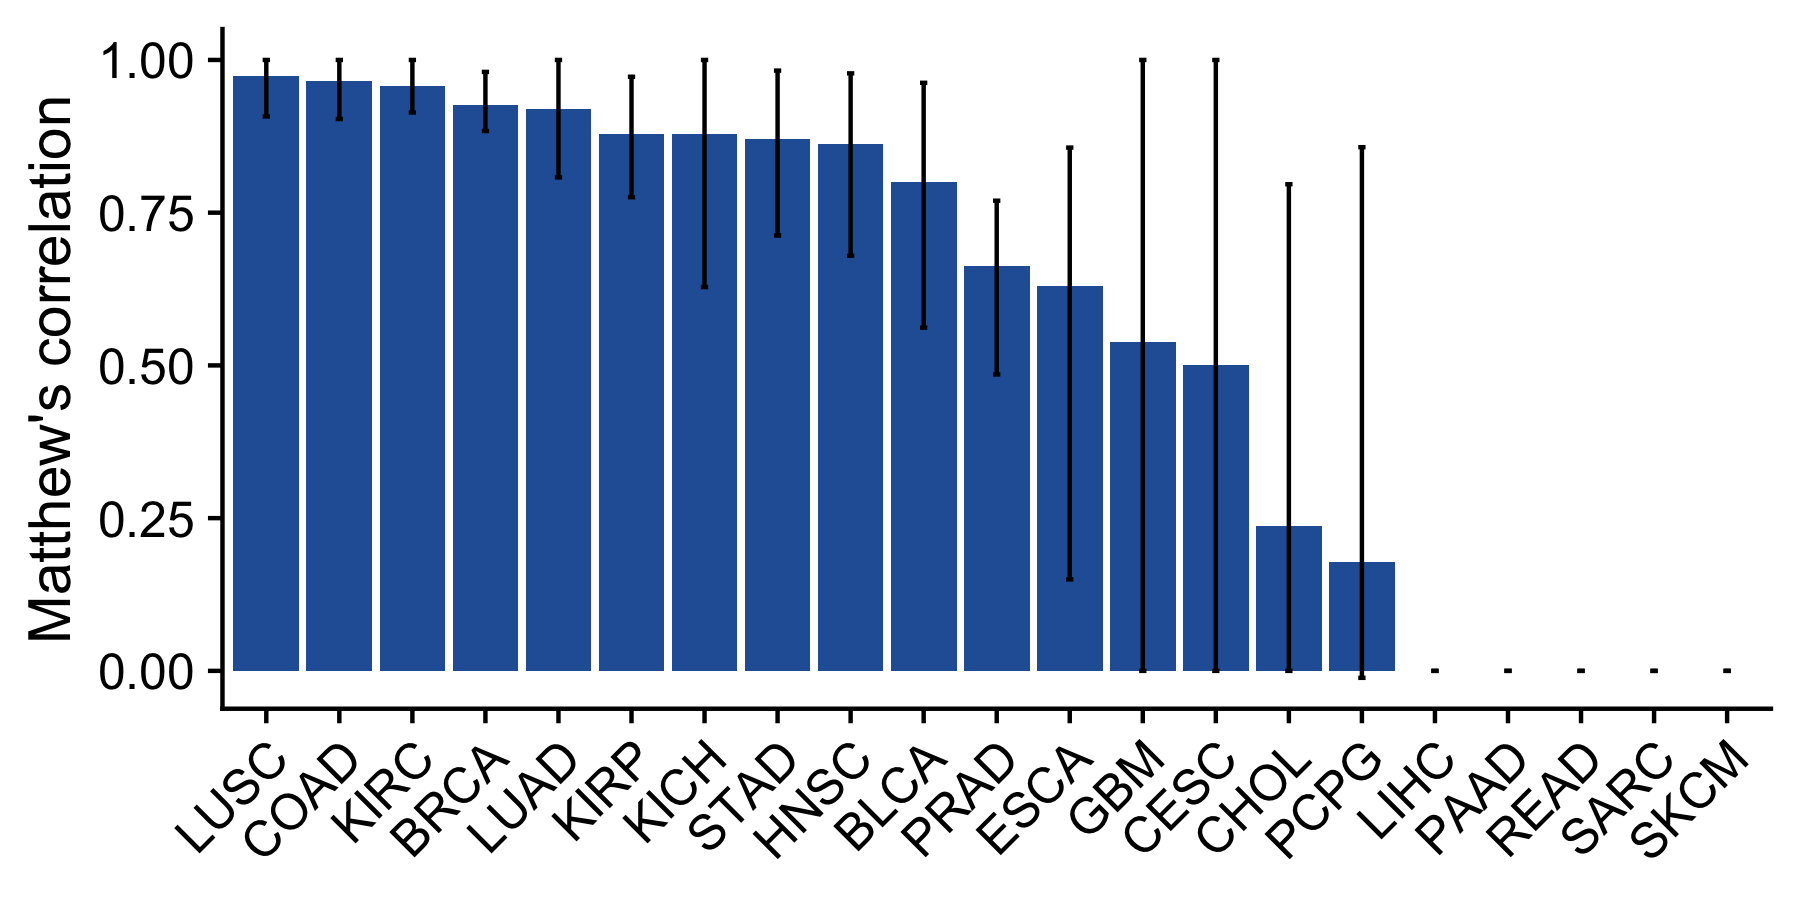

In [9]:
options(repr.plot.height = 3, repr.plot.width = 6, repr.plot.res = 300)

cancer_df %>%
    group_by(tissue) %>%
    summarize(
        conf.low = quantile(mcc, 0.025),
        conf.high = quantile(mcc, 0.975),
        mcc = mean(mcc),
        .groups='drop'
    ) %>%
    mutate(
        tissue = fct_reorder(tissue, mcc, `.desc` = T)
    ) %>%
    ggplot(aes(x = tissue, y = mcc, ymin = conf.low, ymax = conf.high)) +
    geom_col(fill = '#2660a4ff') +
    geom_errorbar(width = 0.1) +
    theme_cowplot() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
        axis.title.x = element_blank()
    ) +
    ylab("Matthew's correlation")

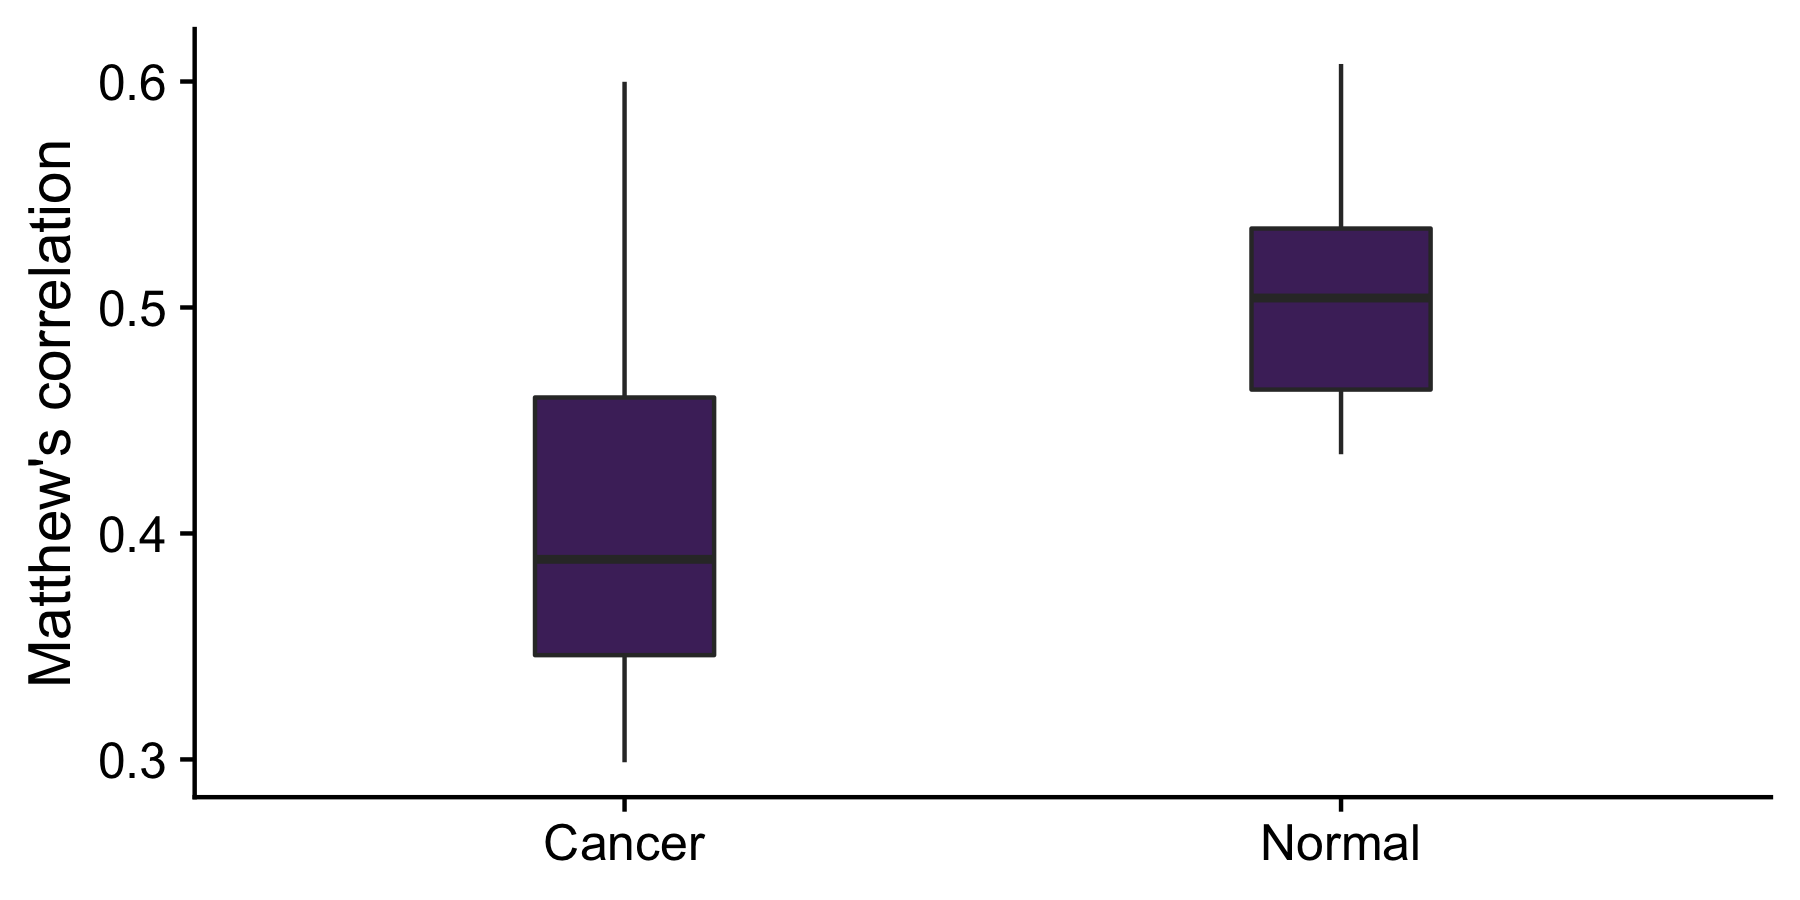

In [124]:
options(repr.plot.height = 3, repr.plot.width = 6, repr.plot.res = 300)

tissue_df %>%
    mutate(
        cancer_state = recode_factor(cancer_state, `1` = 'Cancer', `0` = 'Normal')
    ) %>%
    ggplot(aes(x = cancer_state, y = mcc)) +
    geom_boxplot(fill = '#4c2c69ff', width = 0.25) +
    theme_cowplot() +
    theme(
        axis.title.x = element_blank()
    ) +
    ylab("Matthew's correlation")

# UMAP

In [12]:
umap_df <- read_tsv('umap.tsv', col_types = cols())

In [13]:
umap_df %>% head(2)

UMAP1,UMAP2,tissue,cancer,plot,source
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
3.444597,0.2431079,CESC,Normal,1,Bulk
2.214920,3.7426698,CESC,Normal,1,Bulk


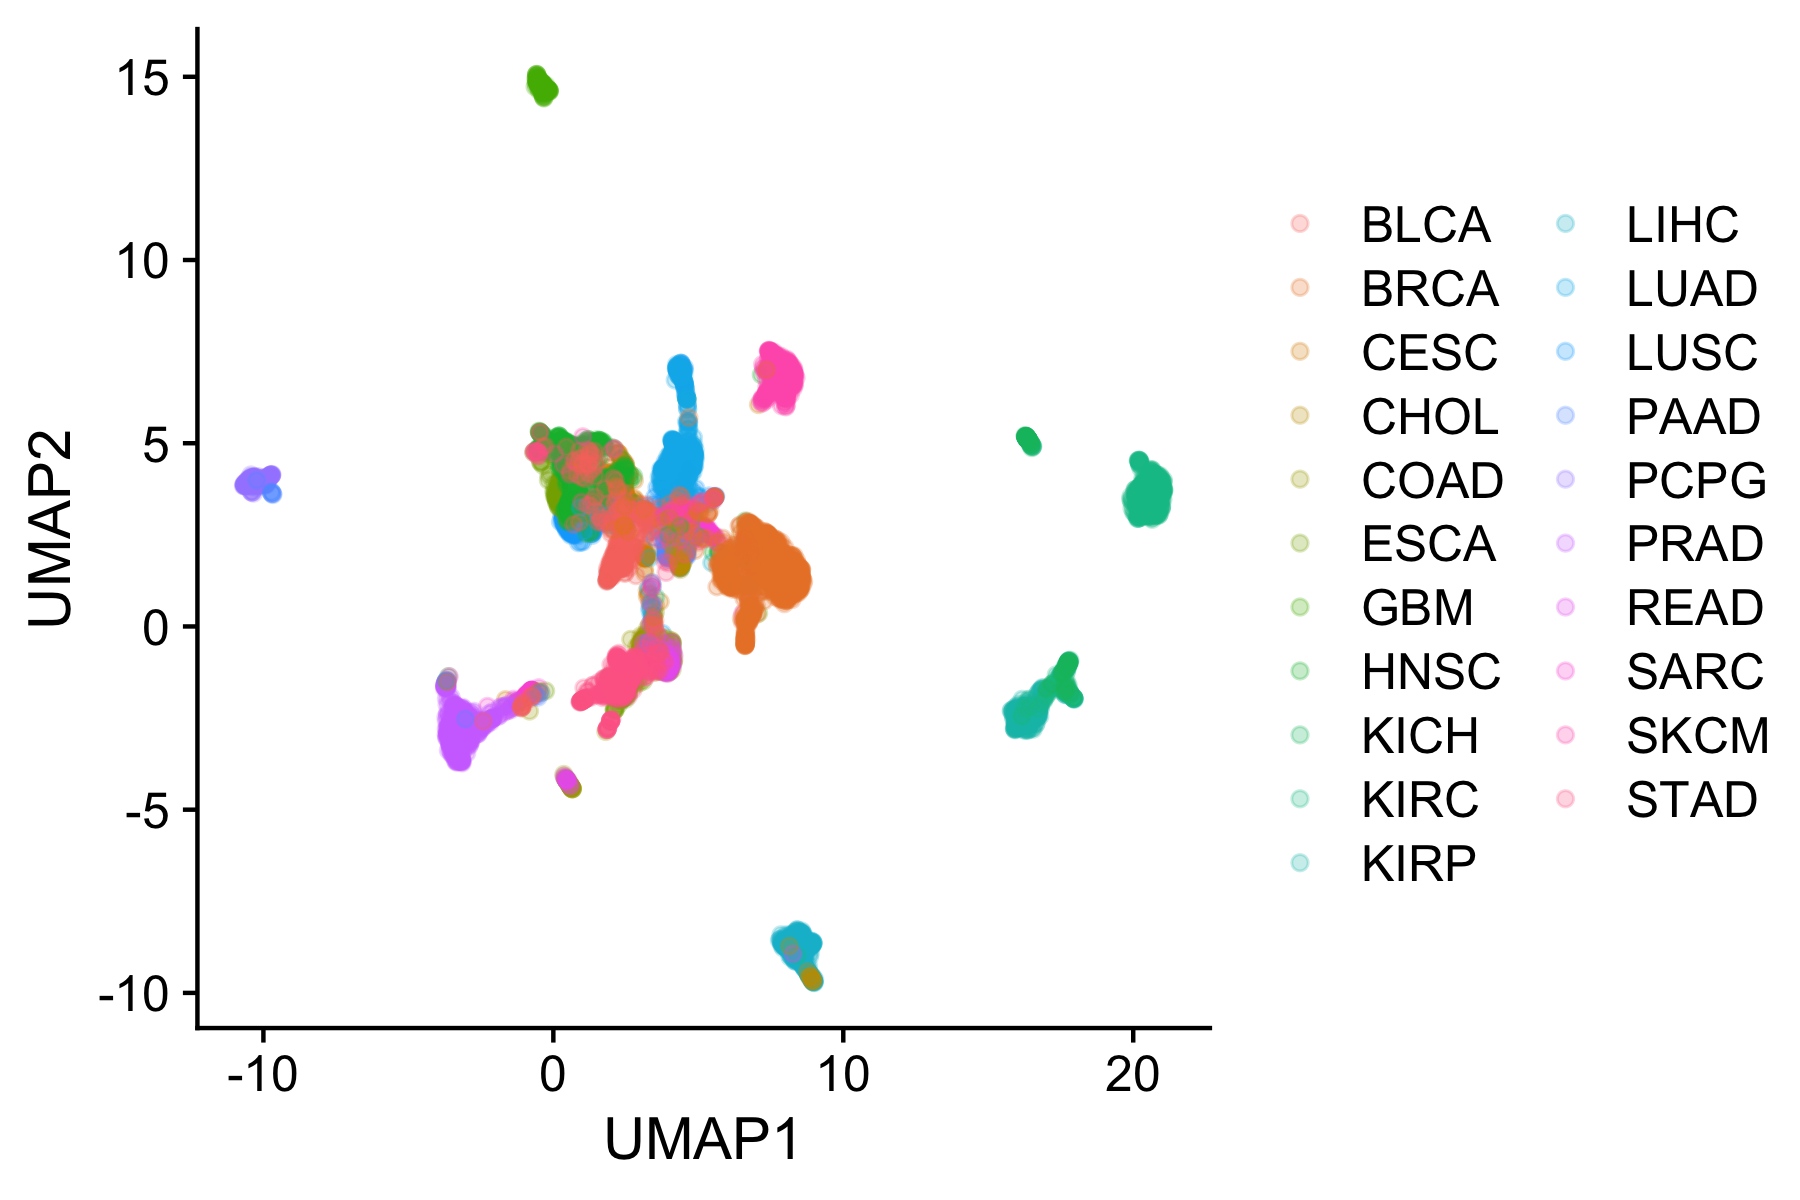

In [17]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 300)

umap_df %>%
    filter(plot == 1) %>%
    ggplot(aes(x = UMAP1, y = UMAP2, color = tissue)) +
    geom_point(alpha = 0.25) +
    theme_cowplot() +
    theme(
        legend.title = element_blank()
    )

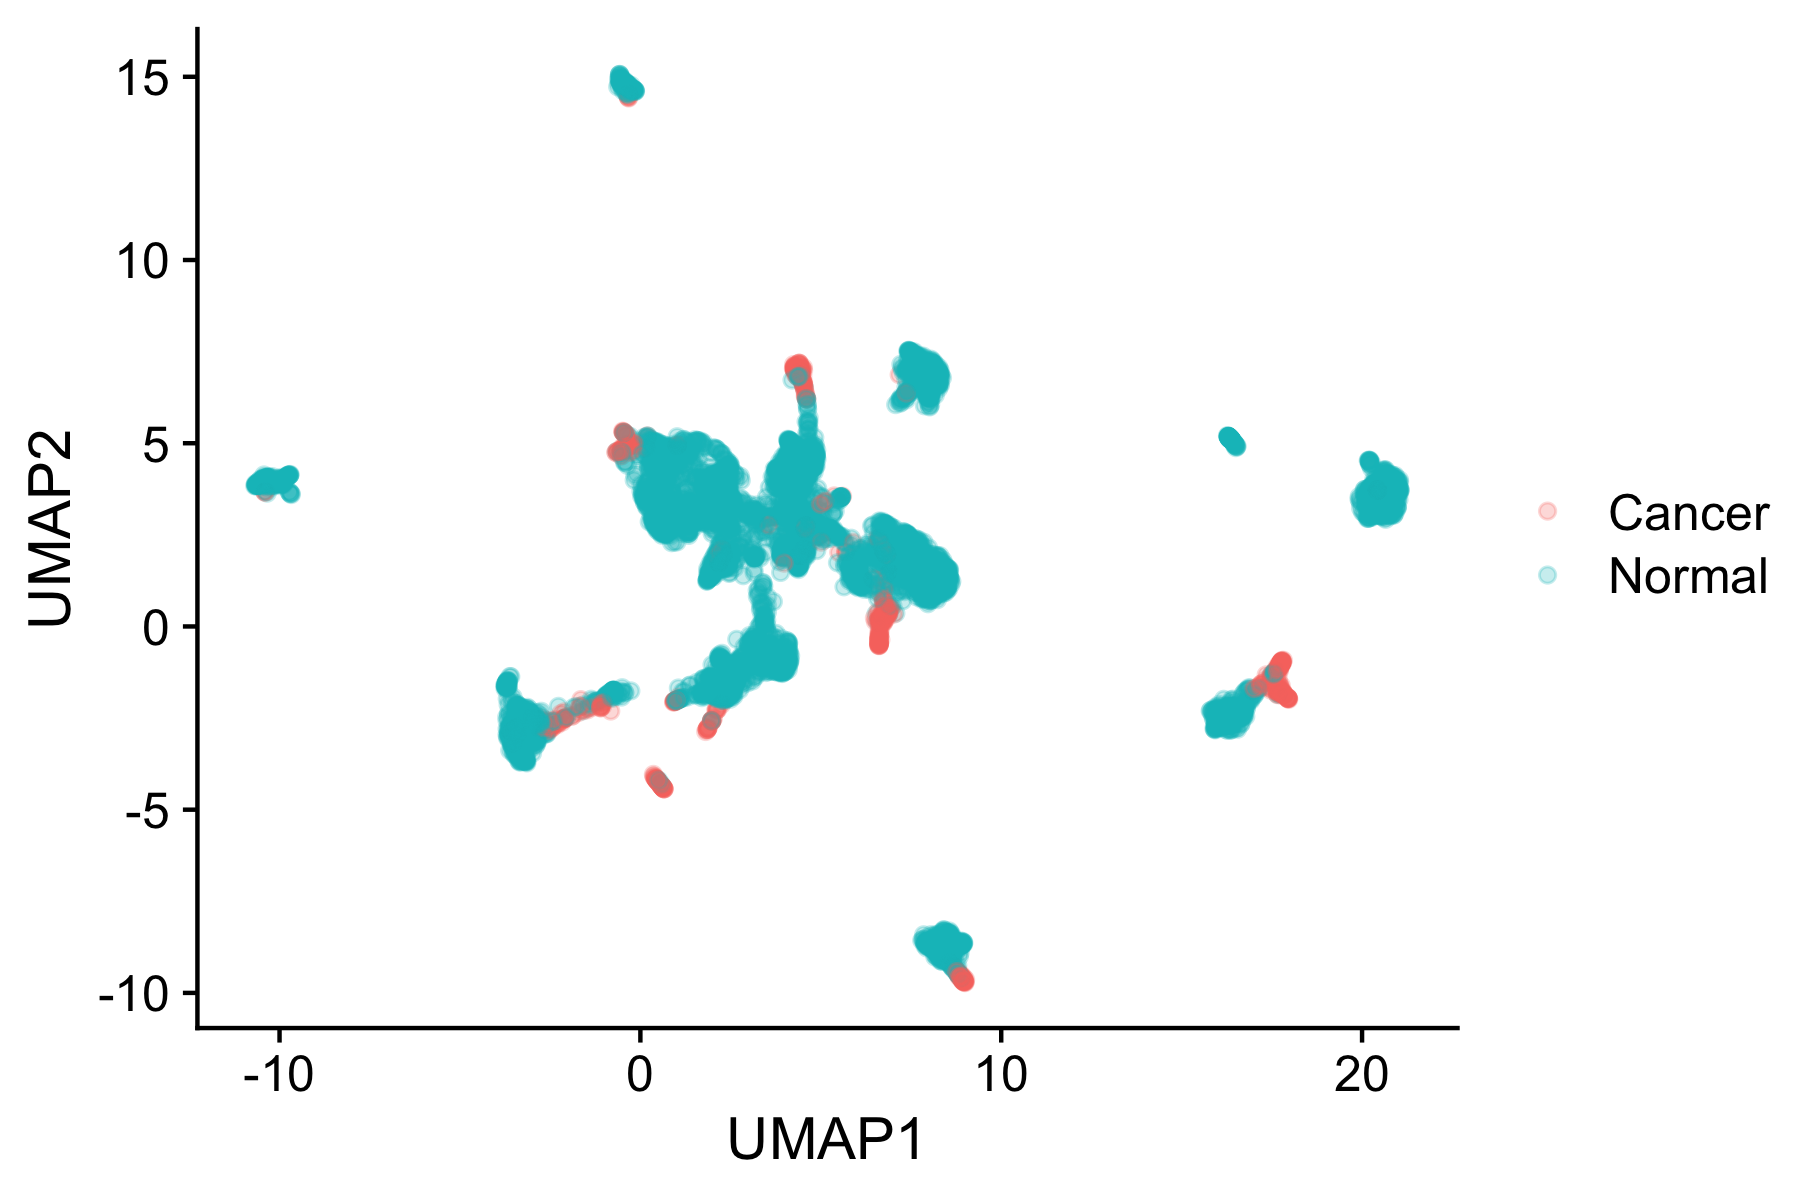

In [18]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 300)

umap_df %>%
    filter(plot == 1) %>%
    ggplot(aes(x = UMAP1, y = UMAP2, color = cancer)) +
    geom_point(alpha = 0.25) +
    theme_cowplot() +
    theme(
        legend.title = element_blank()
    )

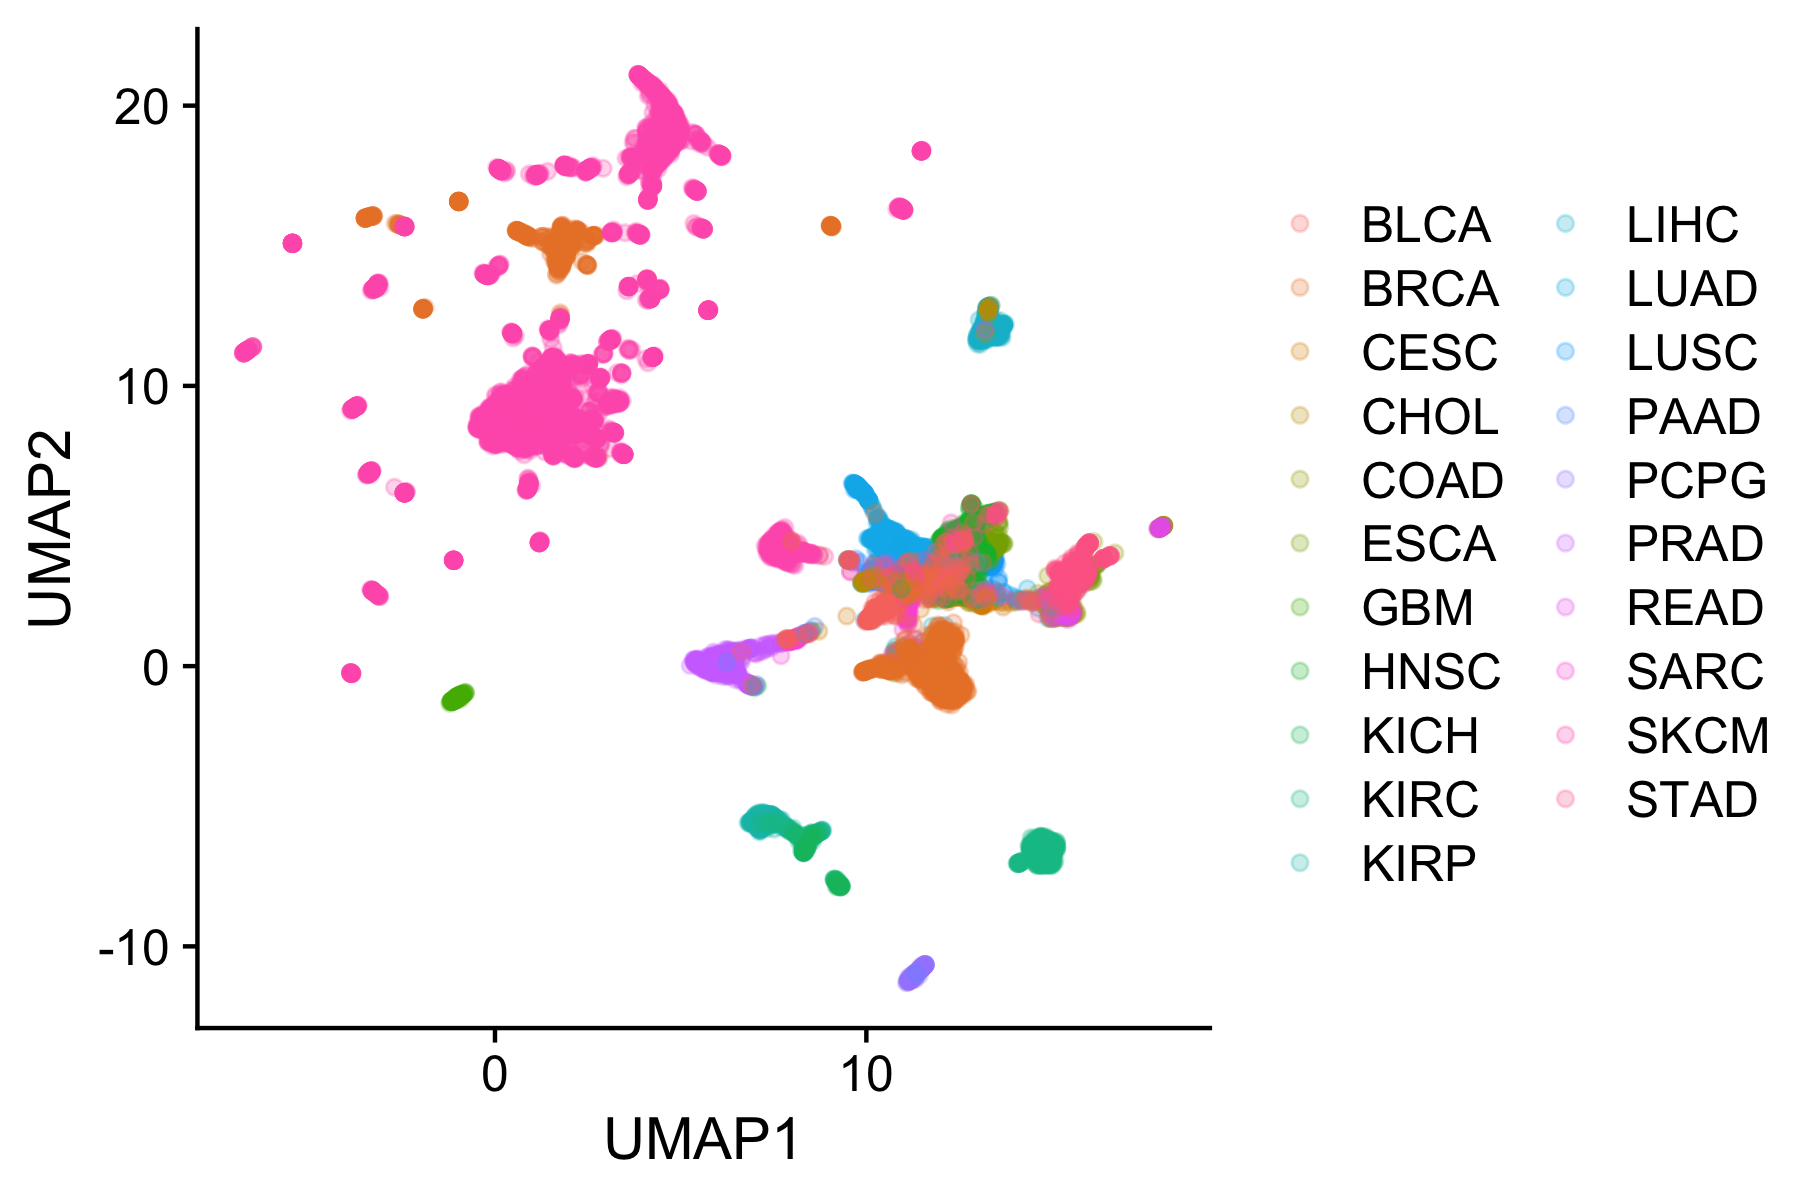

In [19]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 300)

umap_df %>%
    filter(plot == 2) %>%
    ggplot(aes(x = UMAP1, y = UMAP2, color = tissue)) +
    geom_point(alpha = 0.25) +
    theme_cowplot() +
    theme(
        legend.title = element_blank()
    )

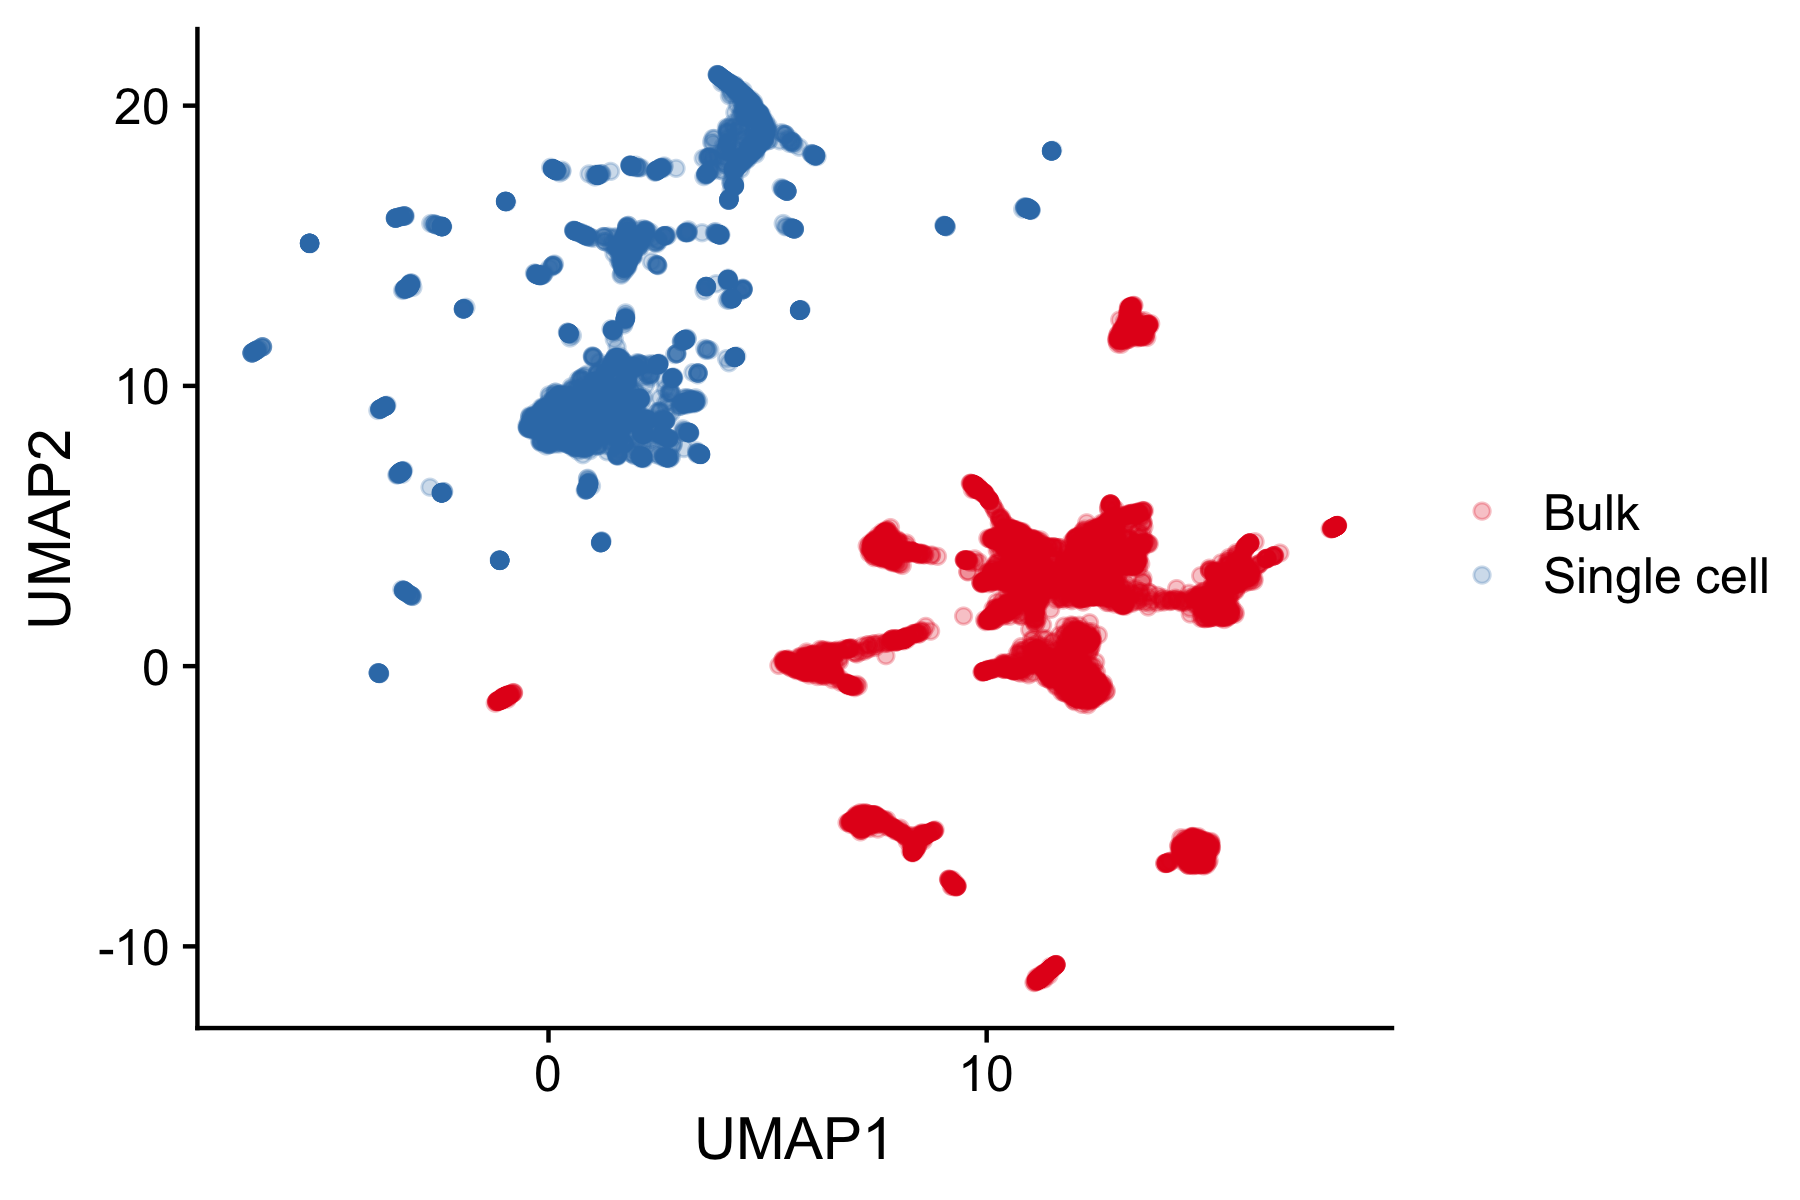

In [25]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 300)

umap_df %>%
    filter(plot == 2) %>%
    ggplot(aes(x = UMAP1, y = UMAP2, color = source)) +
    geom_point(alpha = 0.25) +
    theme_cowplot() +
    theme(
        legend.title = element_blank()
    ) +
    scale_color_brewer(palette = 'Set1')

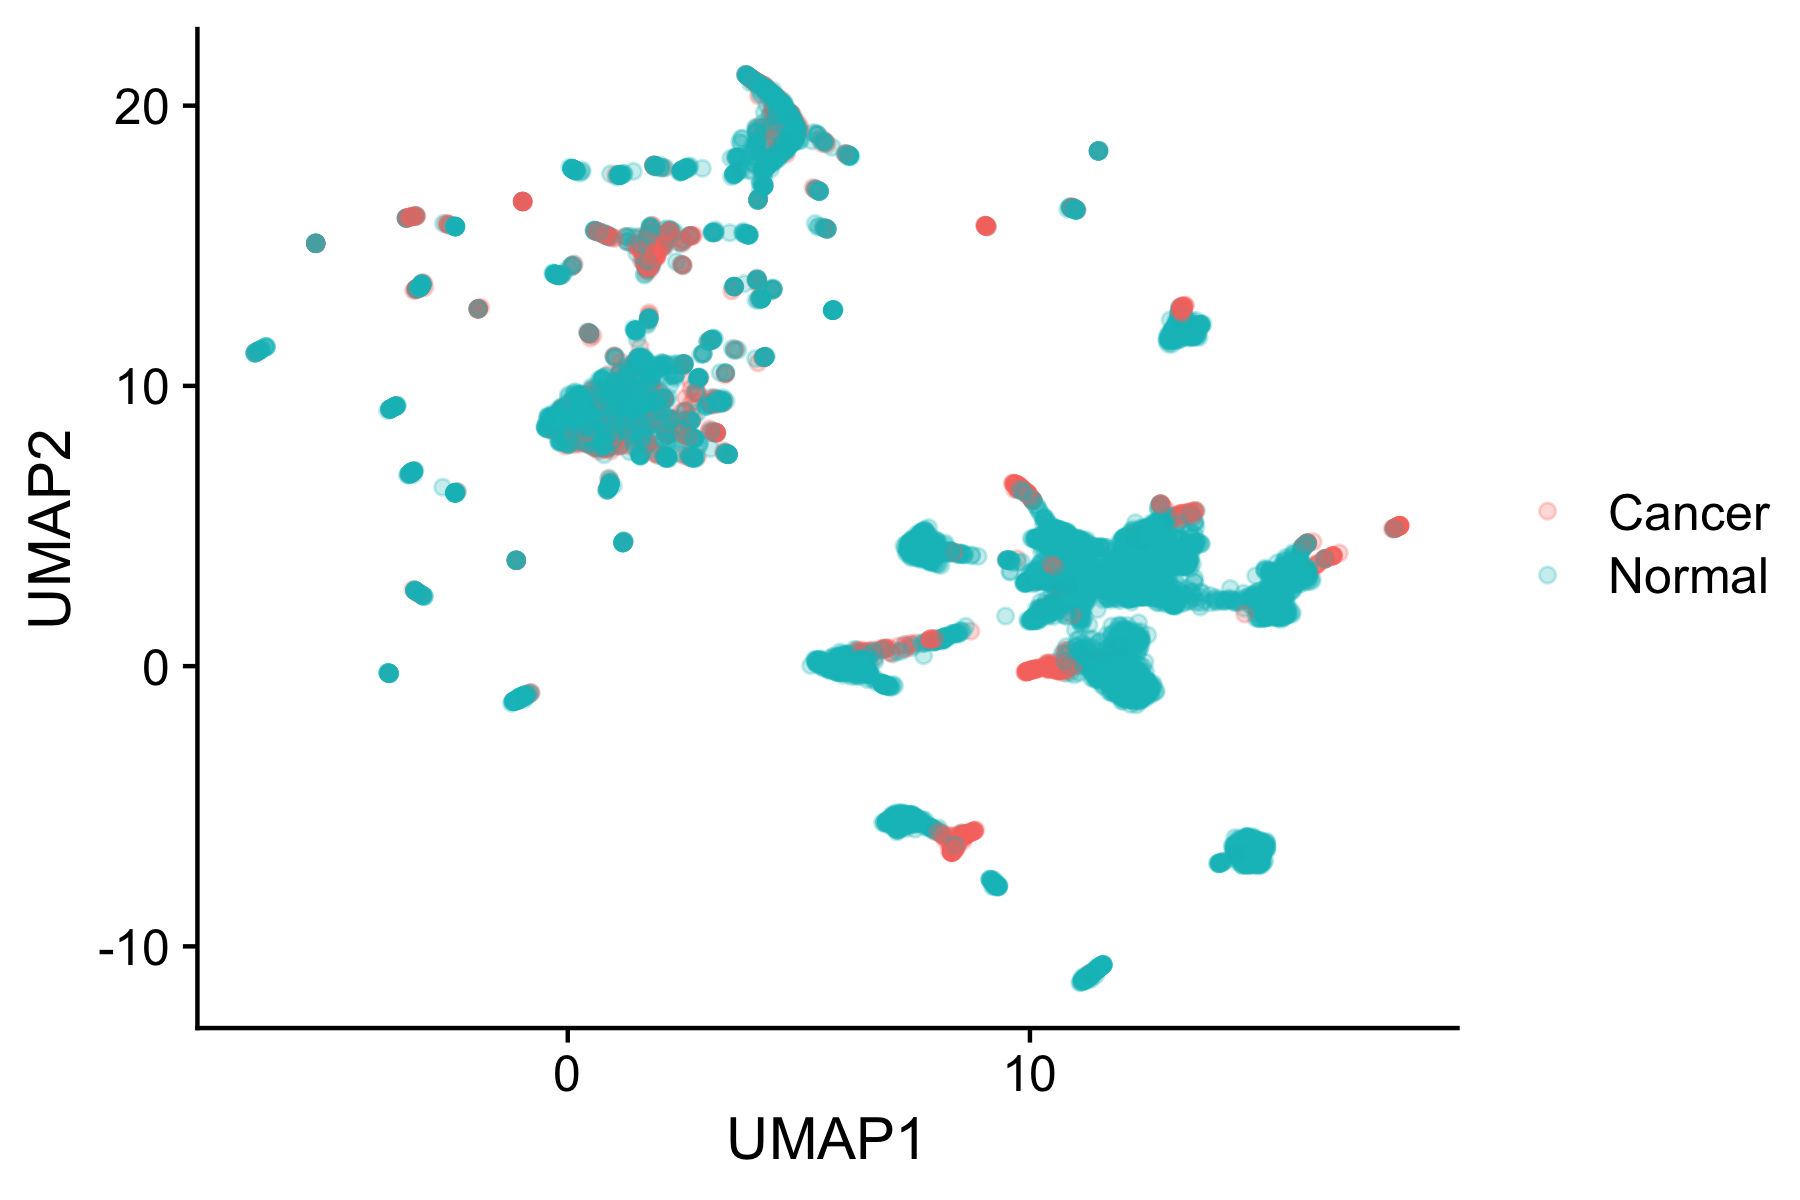

In [20]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 300)

umap_df %>%
    filter(plot == 2) %>%
    ggplot(aes(x = UMAP1, y = UMAP2, color = cancer)) +
    geom_point(alpha = 0.25) +
    theme_cowplot() +
    theme(
        legend.title = element_blank()
    )

# Confusion matrix

In [91]:
confusion_df <- read_tsv('confusion.tsv')

Parsed with column specification:
cols(
  predicted = col_character(),
  true = col_character(),
  cancer = col_double(),
  count = col_double()
)



In [93]:
confusion_df %>% head(2)

predicted,true,cancer,count
<chr>,<chr>,<dbl>,<dbl>
BRCA,BRCA,0,2644
KIRC,KIRC,0,1066


In [139]:
order <- confusion_df %>% distinct(true) %>% pull %>% sort

conf_df <- expand_grid(predicted = order, true = order, cancer = c(0, 1)) %>%
    left_join(confusion_df, by = c('predicted', 'true', 'cancer')) %>%
    replace_na(list(count = 0)) %>%
    mutate(cancer = cancer %>% recode_factor('0' = 'Normal', '1' = 'Cancer')) %>%
    group_by(true, cancer) %>%
    mutate(frac = count / sum(count)) %>%
    ungroup

In [140]:
options(repr.plot.height = 4, repr.plot.width = 9, repr.plot.res = 300)

normal_plot <- conf_df %>%
    filter(cancer == 'Normal') %>%
    ggplot(aes(x = predicted, y = true, fill = frac)) +
    geom_tile() +
    scale_y_discrete(limits = rev(order)) +
    theme_cowplot() +
    theme(
        axis.text.x = element_text(angle = 45, hjust = 1),
        aspect.ratio = 1,
        axis.text = element_text(size = 8)
    ) +
    scale_fill_gradient(low = '#f0f0f0', high = '#636363') +
    xlab("Predicted tissue") +
    ylab('Actual tissue') +
    facet_wrap(vars(cancer))

cancer_plot <- conf_df %>%
    filter(cancer == 'Cancer') %>%
    ggplot(aes(x = predicted, y = true, fill = frac)) +
    geom_tile() +
    scale_y_discrete(limits = rev(order)) +
    theme_cowplot() +
    theme(
        axis.text.x = element_text(angle = 45, hjust = 1),
        aspect.ratio = 1,
        axis.text = element_text(size = 8)
    ) +
    scale_fill_gradient(low = '#f0f0f0', high = '#636363') +
    xlab("Predicted tissue") +
    ylab('Actual tissue') +
    facet_wrap(vars(cancer))

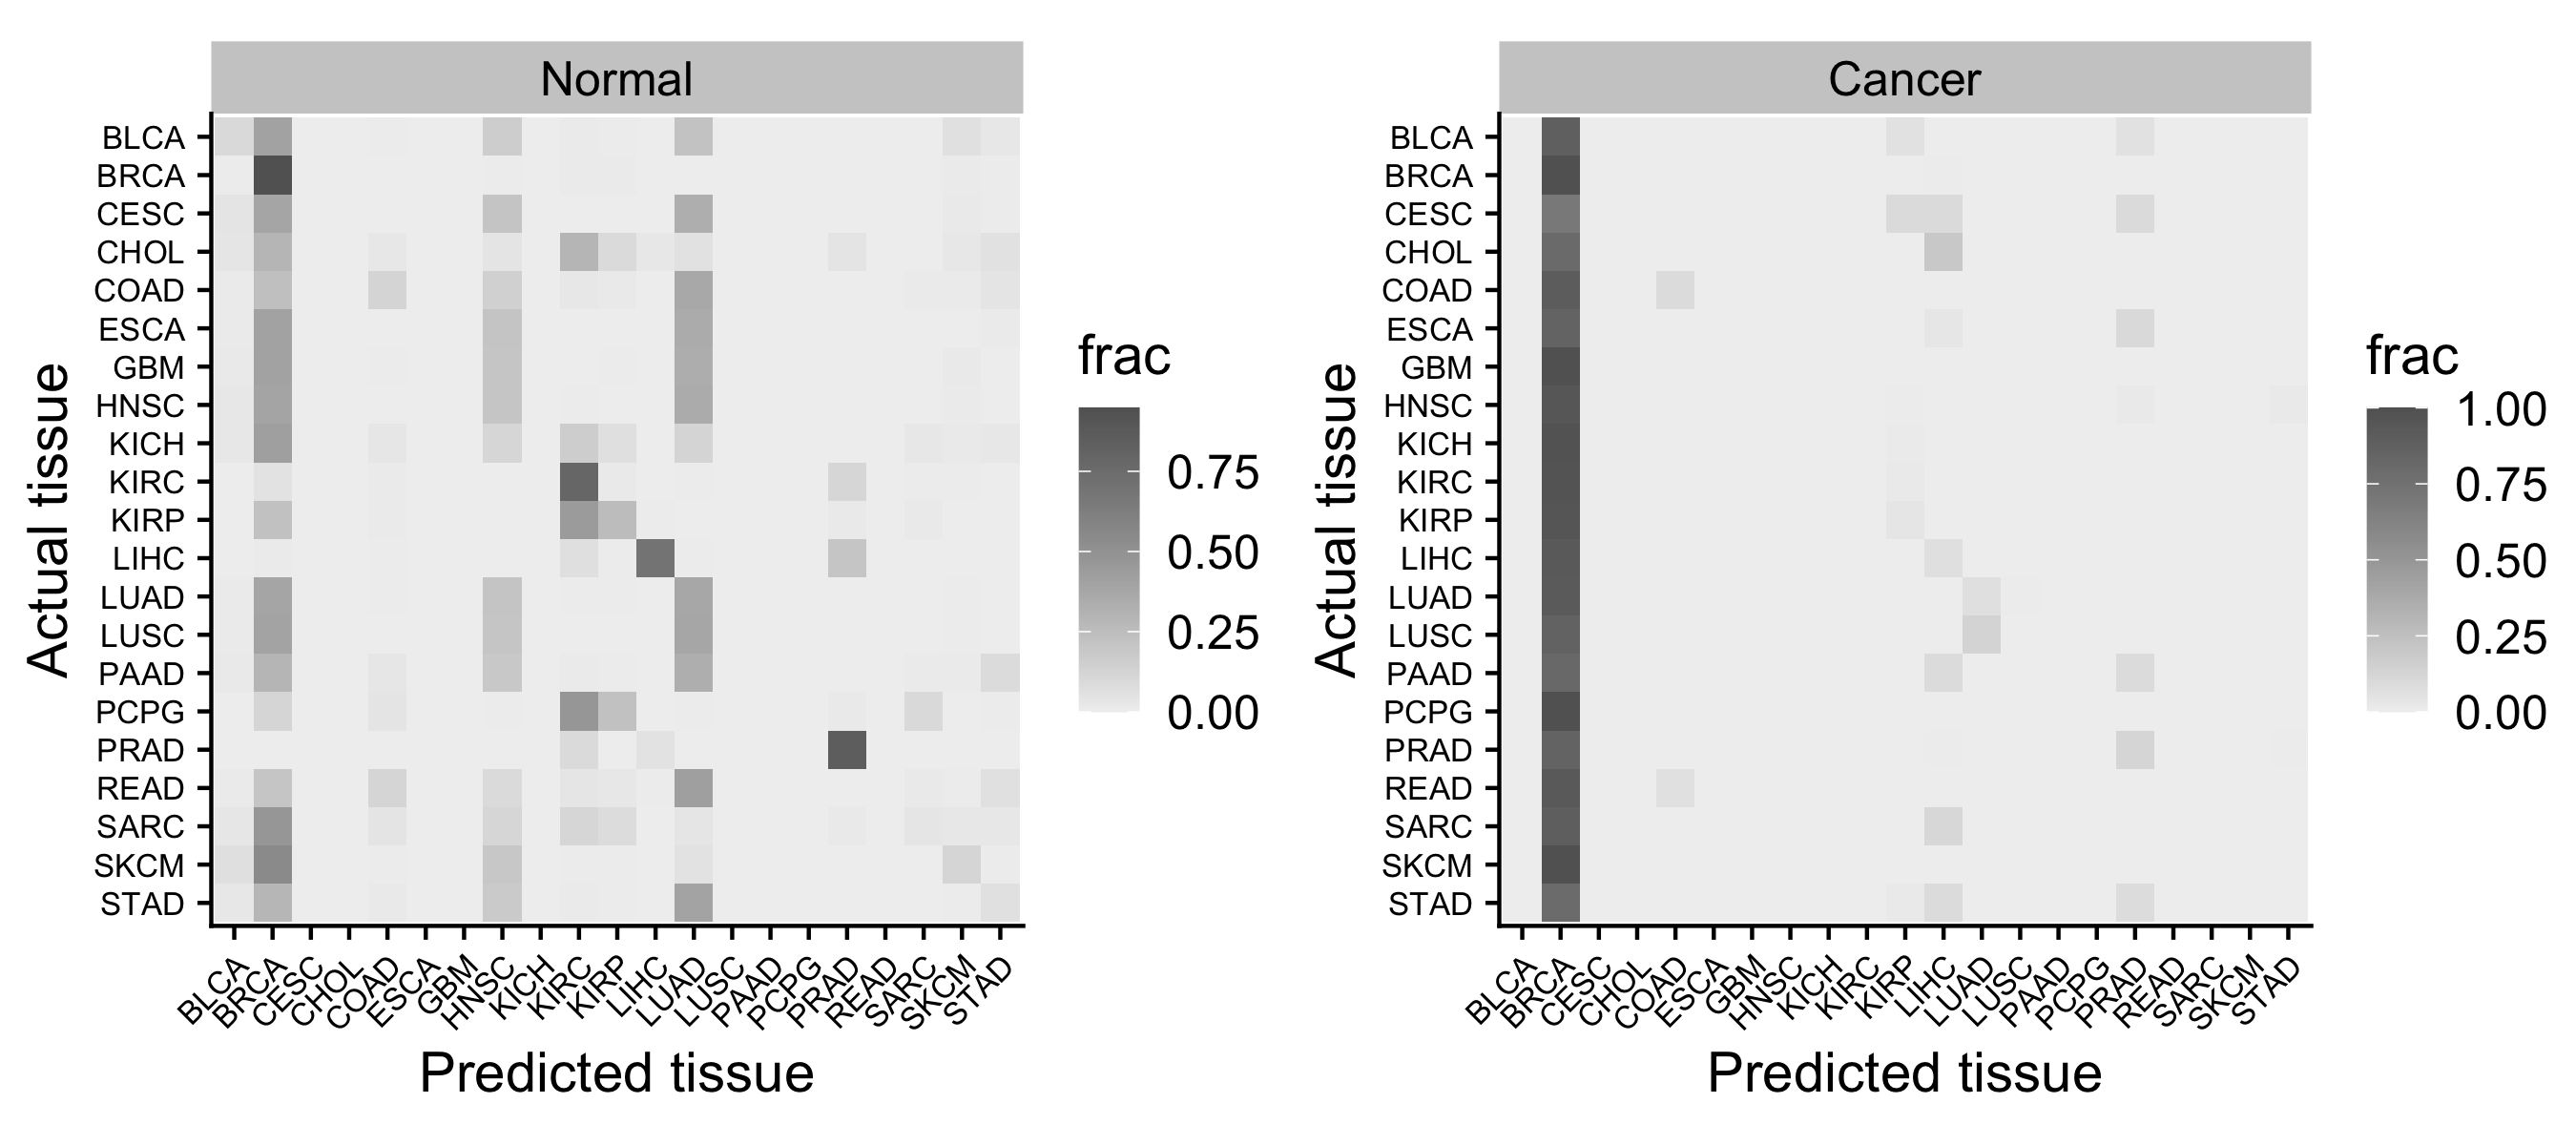

In [141]:
plot_grid(normal_plot, cancer_plot)

In [142]:
confusion_tissue_df <- read_tsv('confusion_tissues.tsv') %>%
    mutate(
        across(c(predicted, true), ~recode_factor(., '0' = 'Normal', '1' = 'Cancer'))
    ) %>%
    group_by(true, tissue) %>%
    mutate(frac = count / sum(count)) %>%
    ungroup

order <- c("Cancer", 'Normal')

Parsed with column specification:
cols(
  predicted = col_double(),
  true = col_double(),
  tissue = col_character(),
  count = col_double()
)



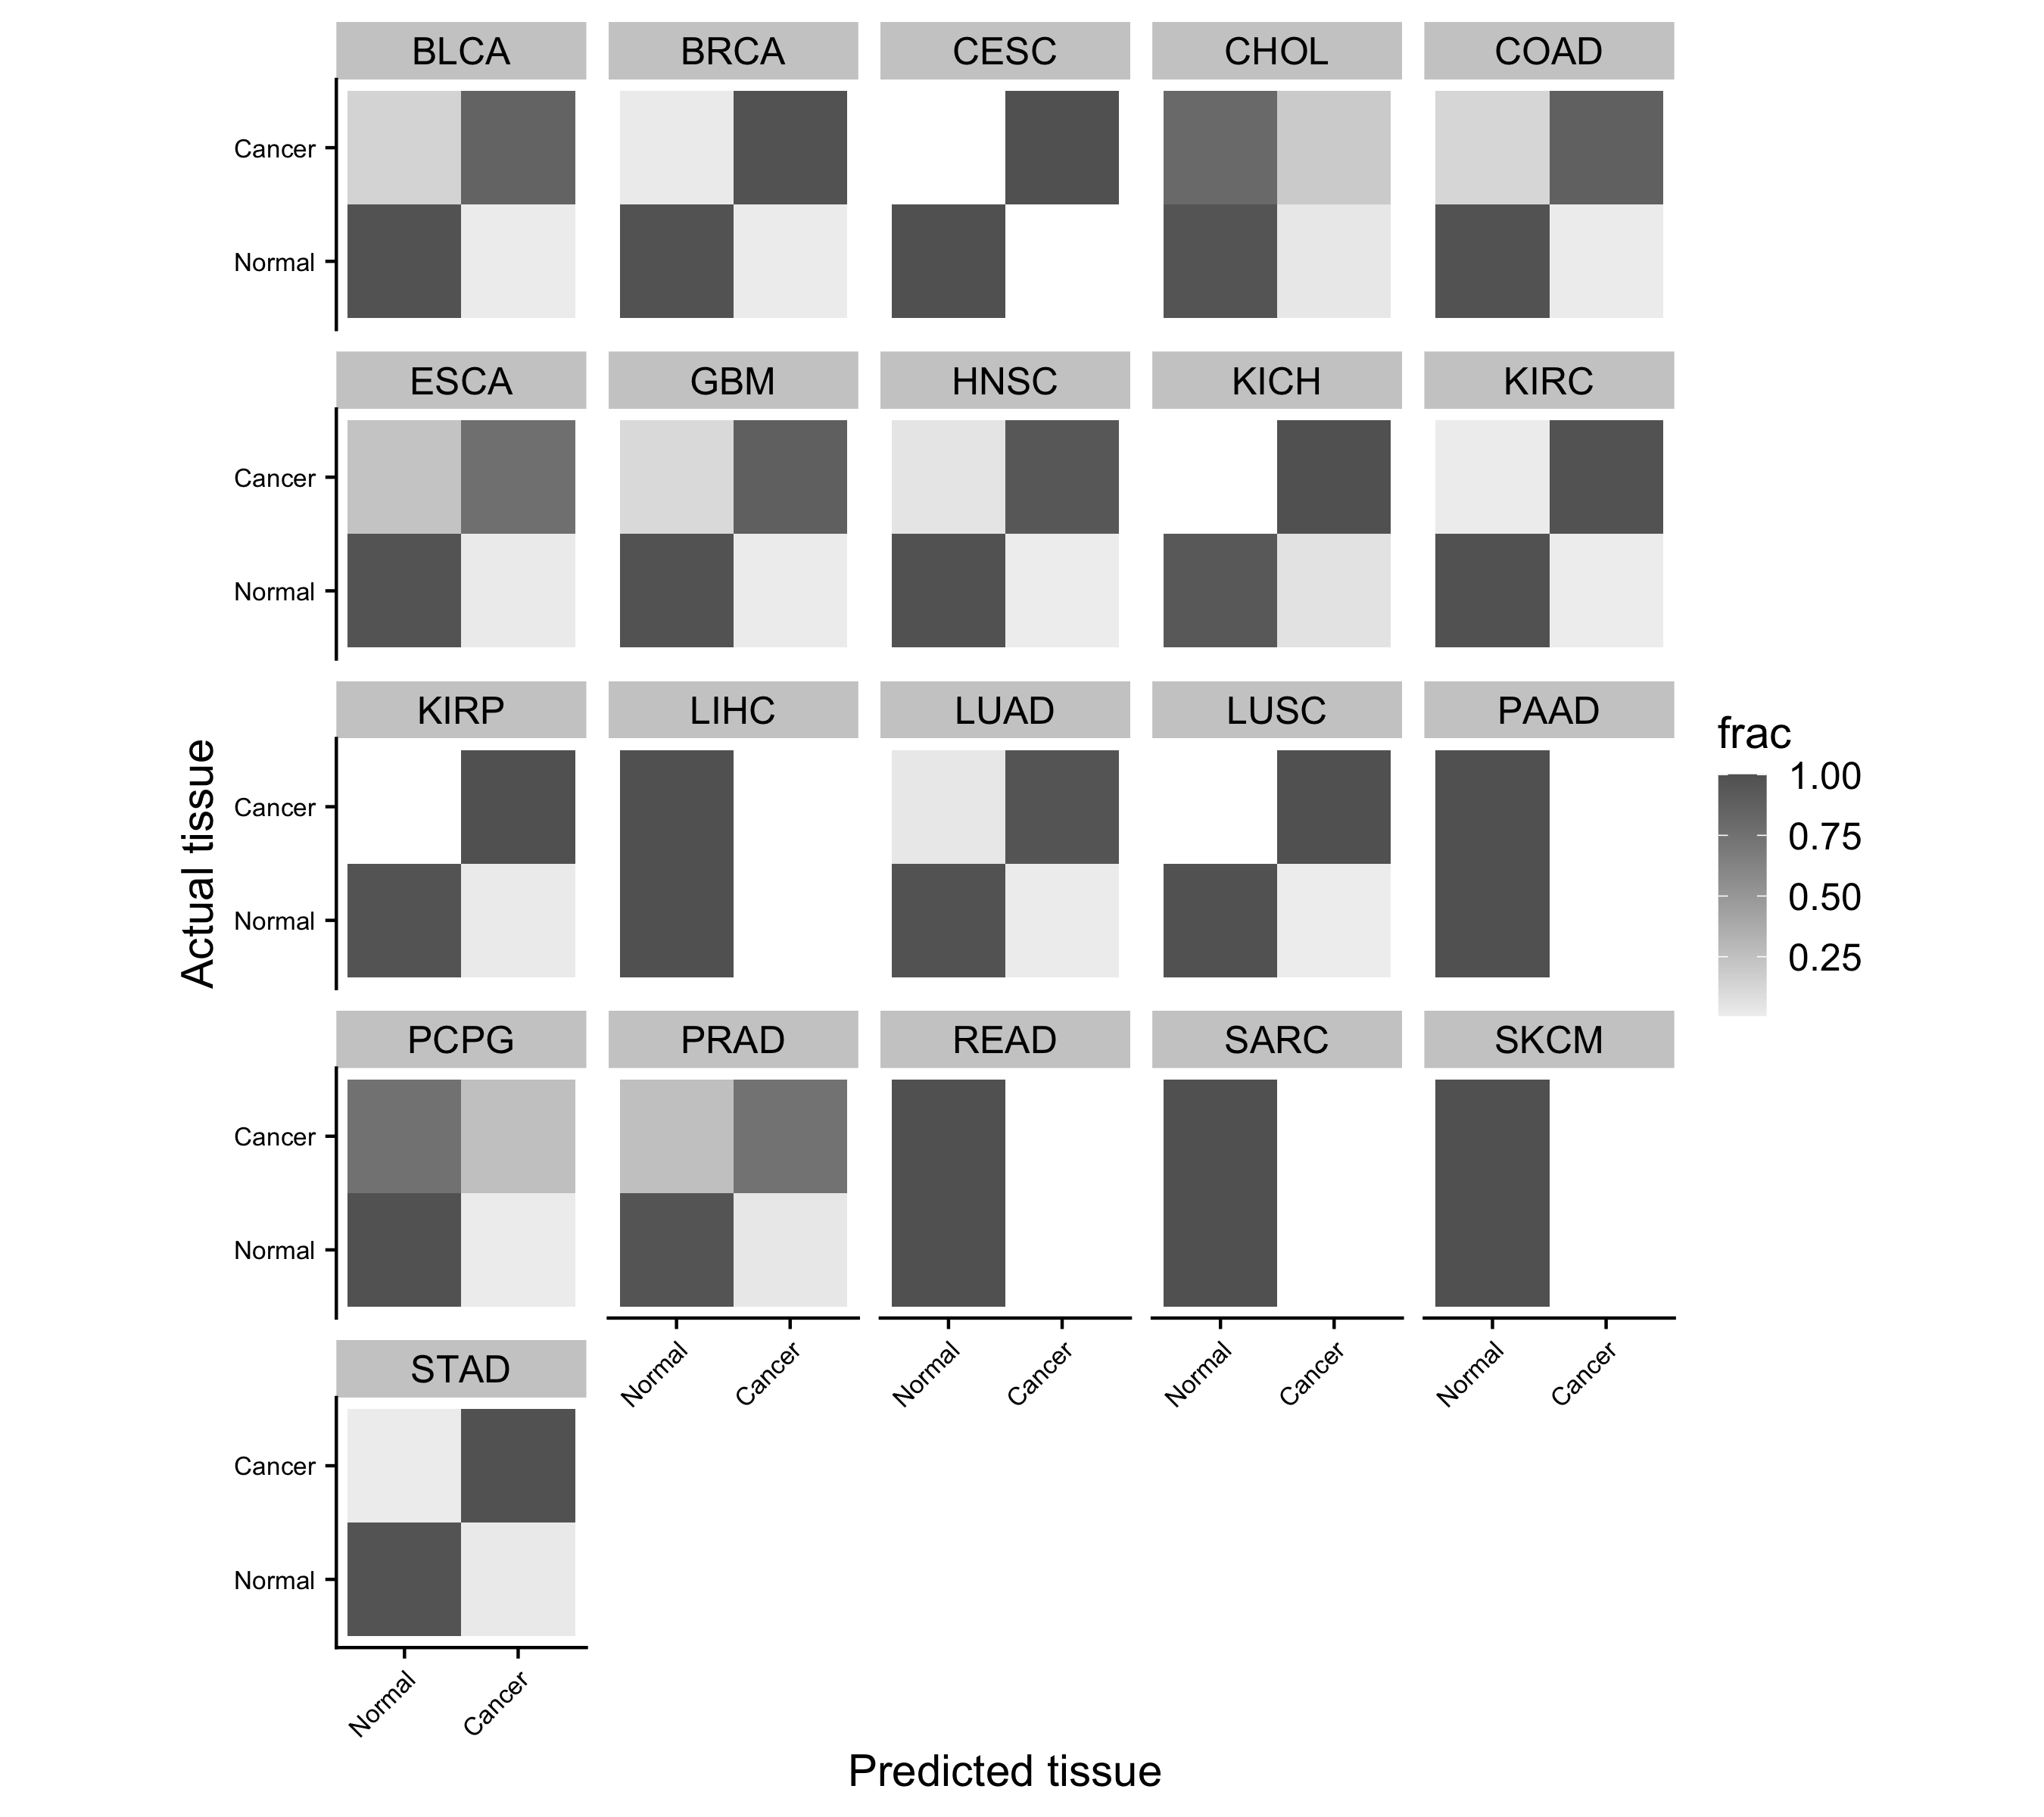

In [143]:
options(repr.plot.height = 8, repr.plot.width = 9, repr.plot.res = 300)

confusion_tissue_df %>%
#     filter(tissue == 'BRCA') %>%
    ggplot(aes(x = predicted, y = true, fill = frac)) +
    geom_tile() +
    scale_y_discrete(limits = rev(order)) +
    theme_cowplot() +
    theme(
        axis.text.x = element_text(angle = 45, hjust = 1),
        aspect.ratio = 1,
        axis.text = element_text(size = 8)
    ) +
    scale_fill_gradient(low = '#f0f0f0', high = '#636363') +
    xlab("Predicted tissue") +
    ylab('Actual tissue') +
    facet_wrap(vars(tissue))